# Moosic Baseline Model :: Iteration v1


* combining datasets as done prior [data preprocessing][data management]
* train test split [modelling]
* baseline model [discussion needed]
* baseline model sketch and implementation


## Importing required libraries




In [1]:
# IMPORT LIBRARIES


try:

    import numpy as np
    import pandas as pd
    import random as rnd
    #from tqdm.notebook import tqdm as tqdm
    from tqdm import tqdm 
    #from .autonotebook import tqdm as notebook_tqdm
    import time

    # databases - sql
    #from dotenv import dotenv_values
    #import sqlalchemy

    # visualisation
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # split data - avoid data leakage
    from sklearn.model_selection import train_test_split

    # preprocessing, scaling
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    # modelling
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans, MiniBatchKMeans

    # cross validation, hyperparameter tuning
    #from surprise.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV

    # metrics
    from sklearn import metrics
    from sklearn.metrics import euclidean_distances, silhouette_score
    from sklearn.metrics.pairwise import sigmoid_kernel, cosine_similarity, pairwise_distances_argmin

    # high dimensional usage - dimensionality reduction
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    # text converter/vectorizer
    from sentence_transformers import SentenceTransformer
    from sklearn.feature_extraction.text import CountVectorizer

    # pipeline
    from sklearn.pipeline import Pipeline



except ImportError as error:
    print(f"Installation of the required dependencies necessary! {error}")

    %pip install numpy
    %pip install pandas
    #%pip install dotenv
    #%pip install sqlalchemy
    %pip install seaborn
    %pip install matplotlib
    %pip install scikit-learn
    %pip install tqdm
    %pip install ipywidgets
    %pip install scikit-surprise
    %pip install sentence-transformers

    print(f"Successful installation of the required dependencies necessary")


import warnings
warnings.filterwarnings('ignore')



# color scheme

- custom_palette = { violet: #2B2960, blue: #00A1D8, orange: #F08144, yellow: #FDC20C, green: #29A744, eggshell: #FFF4D5}


- custom_palette =[#2B2960, #00A1D8, #F08144, #FDC20C, #29A744, #FFF4D5]



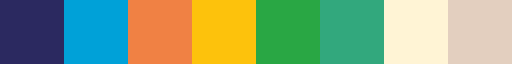

In [22]:


# setting color scheme 


#custom_palette = sns.color_palette(['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#FFF4D5']) #hexcode
#custom_palette_rgb = sns.color_palette(['(43, 41, 96, 1.0)', '(0, 161, 216, 1.0)', '(240, 129, 68, 1.0)', '(253, 194, 12, 1.0)', '(41, 167, 68, 1.0)', '(255, 244, 213, 1.0)']) #rgba values of the hexcodes above

#colors = ListedColormap(custom_palette)

#colors_hex = sns.set_palette(custom_palette)
hex_colors = ['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#32A87D', '#FFF4D5', '#E3CFBF']
custom_cmap_hex = ListedColormap(sns.color_palette(hex_colors).as_hex())


custom_palette = sns.set_palette(sns.color_palette(hex_colors))



custom_cmap_hex

# pandas plot: colormap = custom_cmap_hex, plt/sns plot : cmap = custom_cmap_hex



In [150]:
# set color map style for plots


hex_colors = ['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#32A87D', '#FFF4D5', '#E3CFBF']

custom_palette = sns.set_palette(sns.color_palette(hex_colors))

custom_palette


## Loading the data

In [3]:
# load the data files for artists and tracks


df_artists = pd.read_csv('../data/moosic-raw/spotify_600k_artists.csv', low_memory=False)
df_tracks = pd.read_csv('../data/moosic-raw/spotify_600k_tracks.csv', low_memory=False)


# get shape of the artist and tracks dataframe

print(f"Artists data: There are {df_artists.shape[0]} observations and {df_artists.shape[1]} feature variables ")
print('----------'*10)
print(f"Music Track data: There are {df_tracks.shape[0]} observations and {df_tracks.shape[1]} feature variables ")
print('----------'*10)


Artists data: There are 1162095 observations and 5 feature variables 
----------------------------------------------------------------------------------------------------
Music Track data: There are 586672 observations and 20 feature variables 
----------------------------------------------------------------------------------------------------


## Data Overview Artists

| column | additional information |
|--------|------------------------|
| id | id of artist |
| followers | number of followers | 
| genres | genres associated with artist |
| name | name of artist |
| popularity | popularity of artist in range 0 to 100 |

## Data Overview Tracks

| column | additional information |
|--------|------------------------|
| id | id of track |
| name | name of track | 
| popularity | popularity of track in range 0 to 100 |
| duration_ms | duration of songs in ms |
| explicit | whether it contains explicit content or not |
| artists | artists who created the track | 
| id_artists | id of artists who created the track |
| release_date | date of release |
| danceability | how danceable a song is in range 0 to 1 |
| energy | how energized a song is in range 0 to 1 |
| key | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1 |
| loudness | The overall loudness of a track in decibels (dB) |
| mode |  Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0 |
| speechiness | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks |
| acousticness | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic |
| instrumentalness | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content |
| liveness | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live |
| valence | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry) |
| tempo | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration | 
| time_signature | An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4. | 

---

# Load merged data with genre 

- to be used for modelling

---

In [4]:
# load the data files for artists and tracks


df_musgenre = pd.read_csv('../data/processed/df_with_main_genres_v1.csv', low_memory=False)

# get shape of the artist and tracks dataframe

print(f"Music data: There are {df_musgenre.shape[0]} observations and {df_musgenre.shape[1]} feature variables ")
print('----------'*10)

df_musgenre.head(2)

Music data: There are 457150 observations and 24 feature variables 
----------------------------------------------------------------------------------------------------


,artists_id,track_id,artist_name,track_name,genres,release_date,explicit,duration_ms,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist_popularity,track_popularity,main_genres
0,45tIt06XoI0Iio4LBEVpls,35iwgR4jXetI318WEWsa1Q,Uli,Carve,NaN,1922-02-22,0,126903,0.645,0.445,...,0.674,0.744,0.151,0.127,104.851,3,91.0,6,4,[]
1,14jtPCOoNZwquk5wd9DxrY,021ht4sdgPcrDgSk7JTbKY,Fernando Pessoa,Capítulo 2.16 - Banquero Anarquista,NaN,1922-06-01,0,98200,0.695,0.263,...,0.797,0.000,0.148,0.655,102.009,1,3.0,0,0,[]


In [5]:
## display the info of the data files 

# spotify music data
display(df_musgenre.info())
print('------'*10)


# display a transposed sample of the data file
display(df_musgenre.head().T)
print('------'*10)

# display the number of unique values in the music data
display(df_musgenre.nunique())
print('------'*10)








<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457150 entries, 0 to 457149
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   artists_id         457150 non-null  object 
 1   track_id           457150 non-null  object 
 2   artist_name        457150 non-null  object 
 3   track_name         457150 non-null  object 
 4   genres             419340 non-null  object 
 5   release_date       457150 non-null  object 
 6   explicit           457150 non-null  int64  
 7   duration_ms        457150 non-null  int64  
 8   danceability       457150 non-null  float64
 9   energy             457150 non-null  float64
 10  key                457150 non-null  int64  
 11  loudness           457150 non-null  float64
 12  mode               457150 non-null  int64  
 13  speechiness        457150 non-null  float64
 14  acousticness       457150 non-null  float64
 15  instrumentalness   457150 non-null  float64
 16  li

None

------------------------------------------------------------


,0,1,2,3,4
artists_id,45tIt06XoI0Iio4LBEVpls,14jtPCOoNZwquk5wd9DxrY,5LiOoJbxVSAMkBS2fUm3X2,5LiOoJbxVSAMkBS2fUm3X2,3BiJGZsyX9sJchTqcSA7Su
track_id,35iwgR4jXetI318WEWsa1Q,021ht4sdgPcrDgSk7JTbKY,07A5yehtSnoedViJAZkNnc,08FmqUhxtyLTn6pAh6bk45,08y9GfoqCWfOGsKdwojr5e
artist_name,Uli,Fernando Pessoa,Ignacio Corsini,Ignacio Corsini,Dick Haymes
track_name,Carve,Capítulo 2.16 - Banquero Anarquista,Vivo para Quererte - Remasterizado,El Prisionero - Remasterizado,Lady of the Evening
genres,NaN,NaN,"tango, vintage tango","tango, vintage tango","adult standards, big band, easy listening, lou..."
release_date,1922-02-22,1922-06-01,1922-03-21,1922-03-21,1922
explicit,0,0,0,0,0
duration_ms,126903,98200,181640,176907,163080
danceability,0.645,0.695,0.434,0.321,0.402
energy,0.445,0.263,0.177,0.0946,0.158


------------------------------------------------------------


artists_id            55616
track_id             457150
artist_name           55046
track_name           345152
genres                18513
release_date          18873
explicit                  2
duration_ms           96054
danceability           1190
energy                 2239
key                      12
loudness              25843
mode                      2
speechiness            1649
acousticness           5157
instrumentalness       5402
liveness               1776
valence                1737
tempo                115433
time_signature            5
followers             32401
artist_popularity       100
track_popularity         99
main_genres             604
dtype: int64

------------------------------------------------------------


In [23]:
# # for the music tracks dataset: 
# # -  check for number of null values in each columns

# display(df_musgenre.isnull().sum())
# print('------'*10)

# # - drop null / NaNs values in columns

# df_musgenre = df_musgenre.dropna()
# print('------'*10)

# # - re-check for number of null values in each columns

# display(df_musgenre.isnull().sum())
# print('------'*10)

# # - check for duplicates

# display(df_musgenre.duplicated())
# print('------'*10)

# # get count of duplicated values in tracks dataframe

# display(df_musgenre.duplicated().value_counts())
# print('------'*10)

# # show top 5 rows of data (transposed)

# display(df_musgenre.head().T)
# print('------'*10)



In [7]:
#  check for number of null list values in genre column

display(df_musgenre.main_genres.value_counts())
print('------'*10)


main_genres
['pop']                                 99783
[]                                      75864
['rock']                                40612
['pop', 'rock']                         34143
['jazz']                                16896
                                        ...  
['r&b', 'hip hop', 'pop', 'soul']           1
['folk', 'rock', 'country', 'other']        1
['rock', 'hip hop', 'country']              1
['funk', 'hip hop', 'reggae']               1
['funk', 'folk', 'soul']                    1
Name: count, Length: 604, dtype: int64

------------------------------------------------------------


In [8]:
df_musgenre.head(2)

,artists_id,track_id,artist_name,track_name,genres,release_date,explicit,duration_ms,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist_popularity,track_popularity,main_genres
2,5LiOoJbxVSAMkBS2fUm3X2,07A5yehtSnoedViJAZkNnc,Ignacio Corsini,Vivo para Quererte - Remasterizado,"tango, vintage tango",1922-03-21,0,181640,0.434,0.1770,...,0.994,0.0218,0.212,0.457,130.418,5,3528.0,0,23,[]
3,5LiOoJbxVSAMkBS2fUm3X2,08FmqUhxtyLTn6pAh6bk45,Ignacio Corsini,El Prisionero - Remasterizado,"tango, vintage tango",1922-03-21,0,176907,0.321,0.0946,...,0.995,0.9180,0.104,0.397,169.980,3,3528.0,0,23,[]


In [9]:
# drop rows with main_genres having empty lists 
# drop the 56 rows with null/nan values

moosic_data = df_musgenre.copy(deep=True)
moosic_data = moosic_data.query("main_genres != '[]' ").reset_index(drop=True)
moosic_data = moosic_data.convert_dtypes()

null_rows = moosic_data[moosic_data.isnull().T.any()].index
moosic_data = moosic_data.drop(null_rows)

print(moosic_data.isnull().T.any())
print(moosic_data.shape)

moosic_data.head(2)


0         False
1         False
2         False
3         False
4         False
          ...  
343471    False
343472    False
343473    False
343474    False
343475    False
Length: 343476, dtype: bool
(343476, 24)


,artists_id,track_id,artist_name,track_name,genres,release_date,explicit,duration_ms,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist_popularity,track_popularity,main_genres
0,5ESobCkc6JI4tIMxQttqeg,2wAfHM7Whz67VFbdanhZlk,Bessie Smith,Nobody Knows You When Youre Down and Out,"blues, harlem renaissance, jazz blues, traditi...",1923,0,177133,0.614,0.0423,...,0.996,0.00293,0.183,0.211,89.822,4,116265,41,44,['blues']
1,5ESobCkc6JI4tIMxQttqeg,2AZgaYZSwUosJD71J2N2Zo,Bessie Smith,Taint Nobodys Bizness If I Do,"blues, harlem renaissance, jazz blues, traditi...",1923,0,206600,0.537,0.0443,...,0.996,0.000265,0.152,0.137,80.468,4,116265,30,44,['blues']


---

# Mood groups based on valence values to mapped to mood labels for several moods

* based on validated affect measures and their associated word- mood labels

    ```python 

    mood_1d_labels = {"depressed":(0.0, 0.125) , "sad":(0.0, 0.125) , "fear": (0.0, 0.125),  
                        "neutral":(0.0, 0.125), "content":(0.0, 0.125), 
                        "euphoric": (0.0, 0.125), "energetic":(0.0, 0.125), "happy":(0.0, 0.125)}


    ```
---



In [10]:
# mood targets (y) to music track_name and valence

# Based on the one dimensional (1D) mood indicator valence
# create new column 'mood labels'(text) and 'mood_class'(nominal value) 


mood_val_labels = {"depressed":(0.0, 0.124) , "sad":(0.125, 0.249) , "fear_anxious": (0.250, 0.374),  
                    "neutral":(0.375, 0.490), "calm_content":(0.500, 0.624), 
                    "euphoric": (0.625, 0.749), "energetic":(0.750, 0.874), "happy":(0.875, 1.0)}

mood_1d_labels = ["depressed", "sad", "anxious",  "neutral", "calm", "euphoric", "energetic", "happy"]

mood_valence_values =  [0.0 , 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
mood_1d_class = [0, 1, 2, 3, 4, 5, 6, 7]


# add targets for evaluation for clusters later

moosic_data["mood_label"] = (pd.cut(moosic_data["valence"], bins=mood_valence_values, labels=mood_1d_labels)).astype('string')
moosic_data["mood_class"] = (pd.cut(moosic_data["valence"], bins=mood_valence_values, labels=mood_1d_class)).astype('Int64')

moosic_data.head(2)

,artists_id,track_id,artist_name,track_name,genres,release_date,explicit,duration_ms,danceability,energy,...,liveness,valence,tempo,time_signature,followers,artist_popularity,track_popularity,main_genres,mood_label,mood_class
0,5ESobCkc6JI4tIMxQttqeg,2wAfHM7Whz67VFbdanhZlk,Bessie Smith,Nobody Knows You When Youre Down and Out,"blues, harlem renaissance, jazz blues, traditi...",1923,0,177133,0.614,0.0423,...,0.183,0.211,89.822,4,116265,41,44,['blues'],sad,1
1,5ESobCkc6JI4tIMxQttqeg,2AZgaYZSwUosJD71J2N2Zo,Bessie Smith,Taint Nobodys Bizness If I Do,"blues, harlem renaissance, jazz blues, traditi...",1923,0,206600,0.537,0.0443,...,0.152,0.137,80.468,4,116265,30,44,['blues'],sad,1


In [11]:
# save current 1-D moosic (mood-music) dataset

#moosic_data.to_csv('../data/processed/moosic_data.csv', chunksize=len(moosic_data)//5, index=False)





---

# Splitting the dataset for baseline modelling : 

* train, test split
* drop columns = ['artists_id', 'track_id', 'artist_name', 'genres', 'release_date', 'main_genres', 'explicit', 'mood_label', 'track_name', 'mood_class']

<!---
['artists_id', 'track_id', 'artist_name', 'genres', 
                        'duration_ms', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence',	
                        'tempo', 'time_signature','followers', 'artist_popularity',	'track_popularity', 'main_genres',
                        'release_date', 'main_genres', 'explicit', 'track_name', 'mood_label', 'mood_class']

--->


In [12]:
# train-test-split: splitting the data to avoid data leakage 
# defining X and y

features = moosic_data.columns.tolist()

X = moosic_data[features].drop(['artists_id', 'track_id', 'artist_name', 'genres', 'main_genres',
                        'duration_ms', 'liveness', 'time_signature','followers', 'artist_popularity', 'track_popularity',
                        'release_date',  'explicit', 'track_name',  'mood_label', 'mood_class'], axis = 1)

y = moosic_data[['track_name', 'mood_label', 'mood_class']]#.values.reshape(-1,1)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)



In [13]:
# test data

X_test = X_test.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)



In [14]:
# train data : input features

X_train = X_train.reset_index(drop=True)

X_train.head(2)



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,0.73,0.949,6,-9.442,1,0.0562,0.0836,0.871,0.861,135.001
1,0.735,0.676,7,-8.988,1,0.0278,0.409,0.0172,0.616,118.208


In [15]:
# train data : target? music track name, 
# classify by mood features later based on indicators: 1-D (valence), 2-D (valence -energy)

y_train = y_train.reset_index(drop=True)

y_train.head(2)

,track_name,mood_label,mood_class
0,Phat Planet,energetic,6
1,ให้เธอ,calm,4


---
# MODEL SKETCH : baseline model 

---

### Music track baseline content based recommender system by mood categories

* suggests data (music) based on user's interests? or users mood?
* insights and filter based on feature variables from our data
* ??metric: cosine similarity to measure the similarity of tracks/genres etc

<br>

### Algortihms and Options

* Kmeans clustering algorithm (unsupervised) ~ mini batch

* t-SNE for dimensionality reduction and visualisation based on our mood labels

* similarity modelling based on 1D mood indicator, valence (V)

* baseline focus: content-based recommender system based on user input query 
    - if-else construct based on mood clusters
    - output playlist with 10 randomized music track recommendations based on query
    - mood_choices are :  get users current mood cluster and also their preffered choice for mood choice for a playlist.

* optional baseline: 
    - music track name clustering and similarity measure, 
    - then get mood of clusters based on the average valence of the clusters gotten from the similarity

* options: 
    - svm 
    - text vectorization (cosine similarity)

<br>


---


---

[algo] define  model based on similarity of possible target features and focus

---


In [16]:
# defining models for baseline 
# baseline clustering 


def dimension_reduction(train_data):
    pca = PCA(n_components=2)

    pca_data = pca.fit_transform(train_data)

    return pca_data


def mini_batch_kmeans(train_data, test_data, params = {'n_clusters': 8}, *args, **kwargs):

    model = MiniBatchKMeans(**params)

    model.fit_predict(train_data)
    #model.fit(train_data)
    #clustered_labels = model.fit_predict(train_data)
    #model.fit_predict(train_data)

    cluster_labels = model.labels_ 
    cluster_centers = model.cluster_centers_ 
    sse = model.inertia_


    predictions = model.predict(test_data)


    return predictions, cluster_labels, cluster_centers, sse



In [142]:
# Baseline cluster and dimensionality reduction model

def baseline_model(x_train, y_train, x_test,  cluster_params, sample_size = 50000, *args, **kwargs):

    # n number of samples from input features- x_train
    x_data = x_train.head(sample_size)

    # n number of samples from target features- y_train
    y_data = y_train.head(sample_size) 

    # for test: n number of samples from input features- x_test
    x_test = x_test.head(sample_size)

    # dimensionality reduction 
    pca_start_time = time.time()
    pca_data = dimension_reduction(x_data)
    pca_end_time = time.time()



    # mini batch k-means 
    kme_start_time = time.time()
    predictions, cluster_labels, cluster_centers, sse = mini_batch_kmeans(x_data, x_test, params = cluster_params)
    kme_end_time = time.time()


    x_data["k_clusters"] = pd.Series(cluster_labels, index= x_data.index)


    # initialize 2D t-SNE model and fit data
    tsne = TSNE(n_components = 2, random_state = 42)

    tsne_start_time = time.time()

    baseline_tsne = tsne.fit_transform(x_data)

    tsne_end_time = time.time()

    pca_train_time = pca_end_time - pca_start_time
    kme_train_time = kme_end_time - kme_start_time
    tsne_train_time = tsne_end_time - tsne_start_time

    print(f"Time taken for PCA dimension reduction: {pca_train_time:.2f} seconds")
    print(f"Time taken for Mini-Batch K-Means: {kme_train_time:.2f} seconds")
    print(f"Time taken for t-SNE: {tsne_train_time:.2f} seconds")

    # baseline 2D plot : visualize the clustered data
    plt.figure(figsize = (16, 10))
    plt.scatter(baseline_tsne[:, 0], baseline_tsne[:, 1], c=cluster_labels, cmap=custom_cmap_hex, s=50)
    # for i in np.unique(cluster_labels):
    #     #print(cluster_centers[i][0])
    #     print(cluster_centers[i])
    #     plt.scatter(cluster_centers[i][0], cluster_centers[i][0], marker="x", color='k')

    plt.legend()
    plt.title('Baseline Music - Mood Clusters ', pad=15, fontsize = 20, weight = 'bold', color='#2B2960')
    plt.colorbar()

    get_axes = plt.gca()
    #plt.xticks([]) 
    #plt.yticks([]) 
    xax = get_axes.axes.get_xaxis()
    xax = xax.set_visible(False)

    yax = get_axes.axes.get_yaxis()
    yax = yax.set_visible(False)

    plt.show()
    #plt.savefig('../images/kclusters_count_plot.png', transparent=True)

    final_data = x_data.copy(deep=True)
    final_data["track_name"] =  y_data["track_name"].values
    final_data["mood_label"] =  y_data["mood_label"].values
    final_data["mood_class"] =  y_data["mood_class"].values



    return x_data, final_data, cluster_labels, cluster_centers, sse #, metrics





In [70]:
# train model

# global variables
epochs = 100

# scale the data

#scaledstd_xdata = StandardScaler().fit_transform(X_train)
#scaledstd_xdata

scaled_data = MinMaxScaler().fit_transform(X_train)

x_train_col = X_train.columns.to_list()
x_train_df = pd.DataFrame(scaled_data, columns = x_train_col)
#x_test_df = X_test

#x_train_df.isnull().T.any()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time taken for PCA dimension reduction: 1.41 seconds
Time taken for Mini-Batch K-Means: 0.63 seconds
Time taken for t-SNE: 97.46 seconds


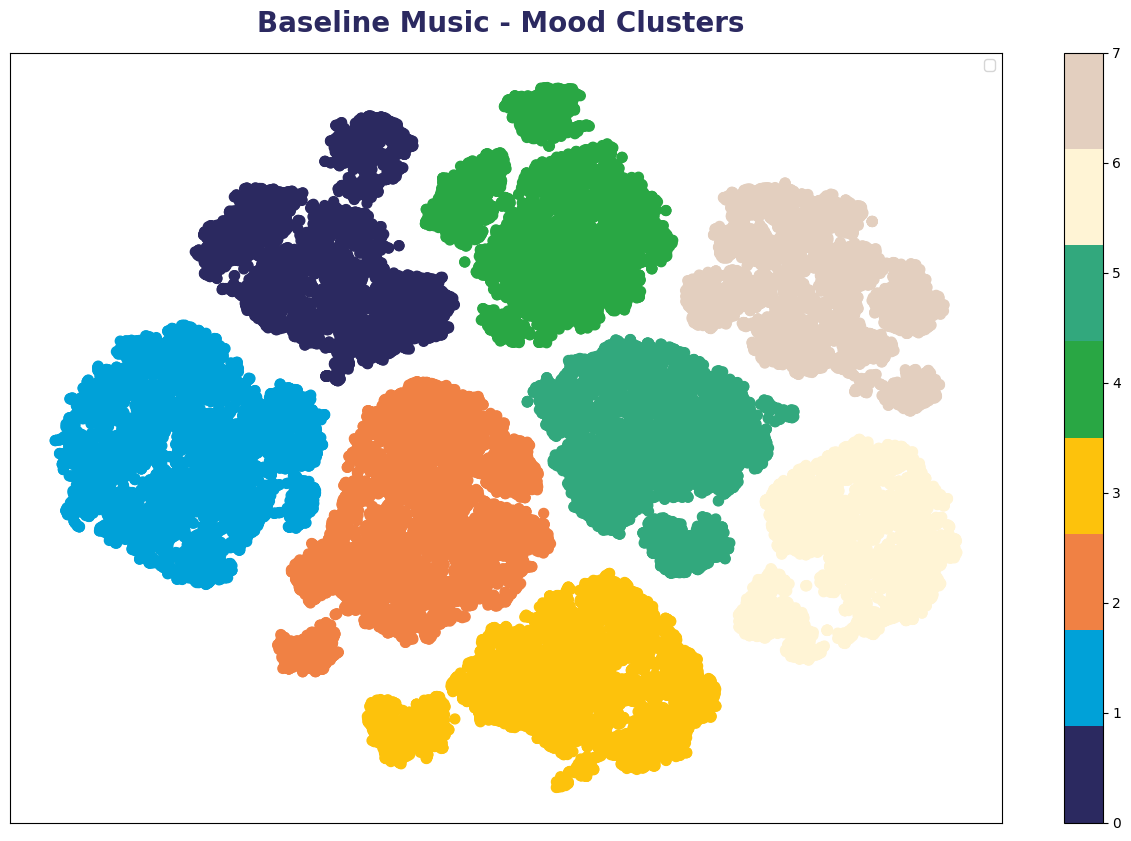

In [71]:

cluster_params = {
    'n_clusters' : 8,
    'batch_size' : 5000,
    'random_state' : 42,
    'init' : 'k-means++' #random
}

#clustered_data,  cluster_labels = baseline_model(x_train_df, y_train, X_test, cluster_params=cluster_params, sample_size = 50000)

clustered_data, final_data, cluster_labels, cluster_centers, sse = baseline_model(x_train_df, y_train, X_test, cluster_params=cluster_params, sample_size = 50000)


In [143]:
# clus_params = {
#     'n_clusters' : 8,
#     'batch_size' : 5000,
#     'random_state' : 42,
#     'init' : 'k-means++' #random
# }


# clus_data, f_data, clus_labels, clus_centers, sse_0 = baseline_model(x_train_df, y_train, X_test, cluster_params=clus_params, sample_size = 50000)


In [72]:
# show data 

clustered_data.head(2)



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,k_clusters
0,0.738866,0.949,0.545455,0.804372,1.0,0.058299,0.083936,0.8710,0.861,0.554403,1
1,0.743927,0.676,0.636364,0.811595,1.0,0.028838,0.410643,0.0172,0.616,0.485440,1


In [78]:
# clustered labels : 1 to 8

cluster_labels

array([1, 1, 3, ..., 7, 3, 1], dtype=int32)

In [137]:
# clustered centers


#type(cluster_centers)

for i in np.unique(cluster_labels):
    print(cluster_centers[i][0])

cluster_centers

0.5217905003331338
0.6480243638180159
0.6147907783092639
0.5316203522741437
0.623496140537666
0.5128809259047427
0.46233448159706153
0.594992739312056


array([[0.5217905 , 0.36397515, 0.52953065, 0.75899686, 0.        ,
        0.06917745, 0.75430475, 0.12488345, 0.45446113, 0.47058515],
       [0.64802436, 0.70312372, 0.71104562, 0.82542776, 1.        ,
        0.07271888, 0.23068553, 0.03122827, 0.76076891, 0.50577422],
       [0.61479078, 0.71124561, 0.11439256, 0.8285984 , 1.        ,
        0.07058305, 0.15574537, 0.04476893, 0.6735457 , 0.51072809],
       [0.53162035, 0.36373865, 0.16141741, 0.76127138, 1.        ,
        0.06671603, 0.74153186, 0.09905631, 0.47445   , 0.476296  ],
       [0.62349614, 0.73556856, 0.81065529, 0.83531972, 0.        ,
        0.08742176, 0.14358015, 0.07899824, 0.61831626, 0.50535584],
       [0.51288093, 0.34494667, 0.71651438, 0.76032783, 1.        ,
        0.06212349, 0.74441816, 0.0965432 , 0.42262012, 0.47099687],
       [0.46233448, 0.72999395, 0.55030684, 0.83726942, 1.        ,
        0.0690403 , 0.0826407 , 0.1278516 , 0.35115826, 0.523908  ],
       [0.59499274, 0.6985804 , 0.2552744

In [ ]:
cluster_labels.n

In [ ]:

for i in cluster
cluster_centers



In [82]:
# how many unique clusters

clustered_data['k_clusters'].nunique()



8

In [86]:
# check for null values in the final data gotten from clustering



null_clustered_rows = final_data[final_data.isnull().T.any()].index
final_data = final_data.drop(null_clustered_rows)

print(final_data['k_clusters'].isnull().T.any())
print(final_data['mood_label'].isnull().T.any())
print(final_data['mood_class'].isnull().T.any())


False
False
False


In [90]:
# show final data containing model prediction for mood clusters, true target labels/class for  the moods of music tracks

display(final_data.head(2))



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,k_clusters,track_name,mood_label,mood_class
0,0.738866,0.949,0.545455,0.804372,1.0,0.058299,0.083936,0.8710,0.861,0.554403,1,Phat Planet,energetic,6
1,0.743927,0.676,0.636364,0.811595,1.0,0.028838,0.410643,0.0172,0.616,0.485440,1,ให้เธอ,calm,4


In [91]:
## get y : target data as mood_labels

y_true_label = final_data['mood_label'] #8 unique named mood clusters
y_true_class = final_data['mood_class'] #8 unique discrete values
y_pred_clusters = final_data['k_clusters'] #8 unique discrete values

print(cluster_labels.size)
print(y_true_label.size)
print(y_true_class.size)
print(y_pred_clusters.size)

50000
49992
49992
49992


In [105]:

print(pd.isna((y_true_class.to_numpy()).any))
print(pd.isna((y_true_class.to_numpy()).all))

#type(y_true_class.values)
#type(y_true_class.to_numpy())
print(type(y_true_class.values.to_numpy()))

False
False
<class 'numpy.ndarray'>


In [106]:

print(pd.isna(y_pred_clusters.any))
print(pd.isna(y_pred_clusters.all))
print(type(y_true_class.values.to_numpy()))


False
False
<class 'numpy.ndarray'>


In [129]:
# # Classification
# # simple baseline classifier
# # univariate data? k_clusters? true labels = mood_class
# # bi-variate? valence - k_clusters? true labels = mood_class

# from sklearn.linear_model import LogisticRegression


# clf_x = final_data['k_clusters'].to_numpy().reshape(-1, 1)
# clf_y = final_data['mood_class'].to_numpy().reshape(-1, 1)
# clf = LogisticRegression(random_state=42).fit(clf_x, clf_y)
# clf.predict(clf_x[:2, :])
# clf.predict_proba(clf_x[:2, :])
# clf.score(clf_x, clf_y)


---

# Clustering/Classification : Error Analysis and Evaluation

* Similarity measures
    - cosine similarity
    - euclidean similarity


* Offline Metrics
    Bbased on the mood clustering
    - Classification report
    - RMSE
    - Precision
    - ROC-curve?
    - F1-Score
    - Silhoute score 
    - Other cluster metrics


---

In [132]:
# Evaluation metrics for the mood clustering



clustering_metrics = [
        # (n_samples, )
        metrics.rand_score,
        metrics.fowlkes_mallows_score,
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.mutual_info_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score
    ]

print(f"For the mini-batch kmeans clustering with:  ")

for metric in clustering_metrics:
    #score_labels = metric(y_true_label.values, cluster_labels)
    score_class = metric(y_true_class.to_numpy(), y_pred_clusters.to_numpy())
    print(f"{metric.__name__} of: {score_class:.2f} ")

print('_______'*10)

cluster_scores_metrics = [
        # (n_samples, 1)
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
    ]


print(f"For the mini-batch kmeans clustering with:  ")

for metric in cluster_scores_metrics:
    #score_labels = metric(y_true_label.values, cluster_labels)
    score_class = metric(y_true_class.to_numpy().reshape(-1,1), y_pred_clusters.to_numpy().reshape(-1,1))
    print(f"{metric.__name__}  of: {score_class:.2f} ")

print('_______'*10)







For the mini-batch kmeans clustering with:  
rand_score of: 0.78 
fowlkes_mallows_score of: 0.17 
homogeneity_score of: 0.09 
completeness_score of: 0.09 
v_measure_score of: 0.09 
mutual_info_score of: 0.18 
adjusted_rand_score of: 0.04 
adjusted_mutual_info_score of: 0.09 
______________________________________________________________________
For the mini-batch kmeans clustering with:  
silhouette_score  of: -0.22 
calinski_harabasz_score  of: 2729.40 
______________________________________________________________________


In [133]:
# similarity between the predicted and actual mood clusters
# by what percentage are they similar?
# rand index score of 0.78
# in terms of % 

RI = 0.78
RI_rate = RI * 100
print(f"The similarity rate between predicted and true clusters is {RI_rate:.2f} %")
print(f"The baseline model predicted clusters is approximately {RI_rate:.2f} % similar to the actual music-mood (1-D) clusters")




Similarity rate between predicted and true clusters is 78.00 %


---

#### analysis of the metrics

For the mini-batch kmeans clustering with:  
* rand_score of: 0.78  means the model is good (okay) with respect to the true mood_class
* fowlkes_mallows_score of: 0.17 , bad or moderate cluster prediction by the model?
* homogeneity_score of: 0.09, low score indicates the clusters are not highly homogeneous with respect to the predicted mood_class labels 
* completeness_score of: 0.09, low score indicates that some data points of the same class are split across predicted by the model clusters 
* v_measure_score of: 0.09 , okay/bad? quality of clustering
* mutual_info_score of: 0.18, an okay level of shared information 
* adjusted_rand_score of: 0.04 , low level beyond what is expected by chance
* adjusted_mutual_info_score of: 0.09 , low/okay level of agreement beyond what is expected by chance

<br>

For the mini-batch kmeans clustering with:  
* silhouette_score of: -0.22 , negative, the clusters overlap and are not well separated
* calinski_harabasz_score of: 2729.40 , better separation between clusters? , low within-cluster variance due to high value

<br>

* rand_score measures: the similarity of the predicted clusters and the true clusters for the mood music data, 0 (not a good match/clustering) to 1 (perfect identical to true clusters) 
* fowlkes_mallows_score: the similarity of the predicted clusters and the true clusters for the mood music data, 0 (not a good match/clustering) to 1 (perfect) 
* homogeneity_score: a measure of how much each cluster contains only data points that belong to a single class
* completeness_score: a measure of how well all cluster data points that belong to the same class are assigned to the same cluster
* v_measure_score: the harmonic mean of homogeneity and completeness, a balanced measure of the quality of clusters 
* mutual_info_score: the measure of the amount of information shared between true and predicted clusters
* adjusted_rand_score: a variation of the rand index score that accounts for chance
* adjusted_mutual_info_score: a variation of the mutual info score that accounts for chance
* silhouette_score : it measures the quality of clusters by evaluating how similar each data point is to its own cluster compared to other clusters
* calinski_harabasz_score: the variance ratio criterion, it measures the cluster quality based on between-cluster and within-cluster variance



<br>

In summary, the model 

* was able to cluster 78% of the data to the right mood clusters for the music tracks based on valence and other audio features
* thus the baseline model predicted clusters is approximately 78 % similar to the actual music-mood (1-D) clusters
* also show that clusters are not well separated and a lot of music data belonging to similar clusters were not sisigned to the same ones
* the music tracks smaples seem to belong to multiple mood classes



---


In [144]:
# classification_metrics = [
#         # (n_samples, n_classes)
#         #metrics.roc_auc_score,
#         #metrics.accuracy_score,
#         #metrics.balanced_accuracy_score,
#         #metrics.f1_score,
#         #metrics.jaccard_score,
#         metrics.classification_report,
#         #metrics.confusion_matrix
#     ]

# k_clusters = (y_true_class.nunique())
# n_samples = (y_true_class.to_numpy().size)//k_clusters

# print(f"For the label classification based on clustering :  ")

# for metric in classification_metrics:
#     # reshape (n_samples, ) to (n_samples, k_clusters)
    
#     #score_class = metric(y_true_class.to_numpy().reshape((n_samples, k_clusters)), y_pred_clusters.to_numpy().reshape((n_samples, k_clusters)))
#     score_class = metric(y_true_class.to_numpy().reshape((n_samples, k_clusters)), y_pred_clusters.to_numpy().reshape((n_samples, k_clusters)))

#     print(f"{metric.__name__} score of: {score_class:.2f} ")





---

# Predictions and Results

* predict valence clusters on test data
* ...
* ...

<br>


---

---

# Visualisations

* mood clusters plot 
* prediction plots
* etcs

<br>

---

In [145]:
# show data again 

final_data.head(2) 

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,k_clusters,track_name,mood_label,mood_class
0,0.738866,0.949,0.545455,0.804372,1.0,0.058299,0.083936,0.8710,0.861,0.554403,1,Phat Planet,energetic,6
1,0.743927,0.676,0.636364,0.811595,1.0,0.028838,0.410643,0.0172,0.616,0.485440,1,ให้เธอ,calm,4


In [159]:
final_data_plot = final_data[['k_clusters', 'mood_class']].melt(var_name='Music mood clusters', value_name= 'Mood labels' )
final_data_plot

,Music mood clusters,Mood labels
0,k_clusters,1
1,k_clusters,1
2,k_clusters,3
3,k_clusters,3
4,k_clusters,4
...,...,...
99979,mood_class,7
99980,mood_class,7
99981,mood_class,6
99982,mood_class,5


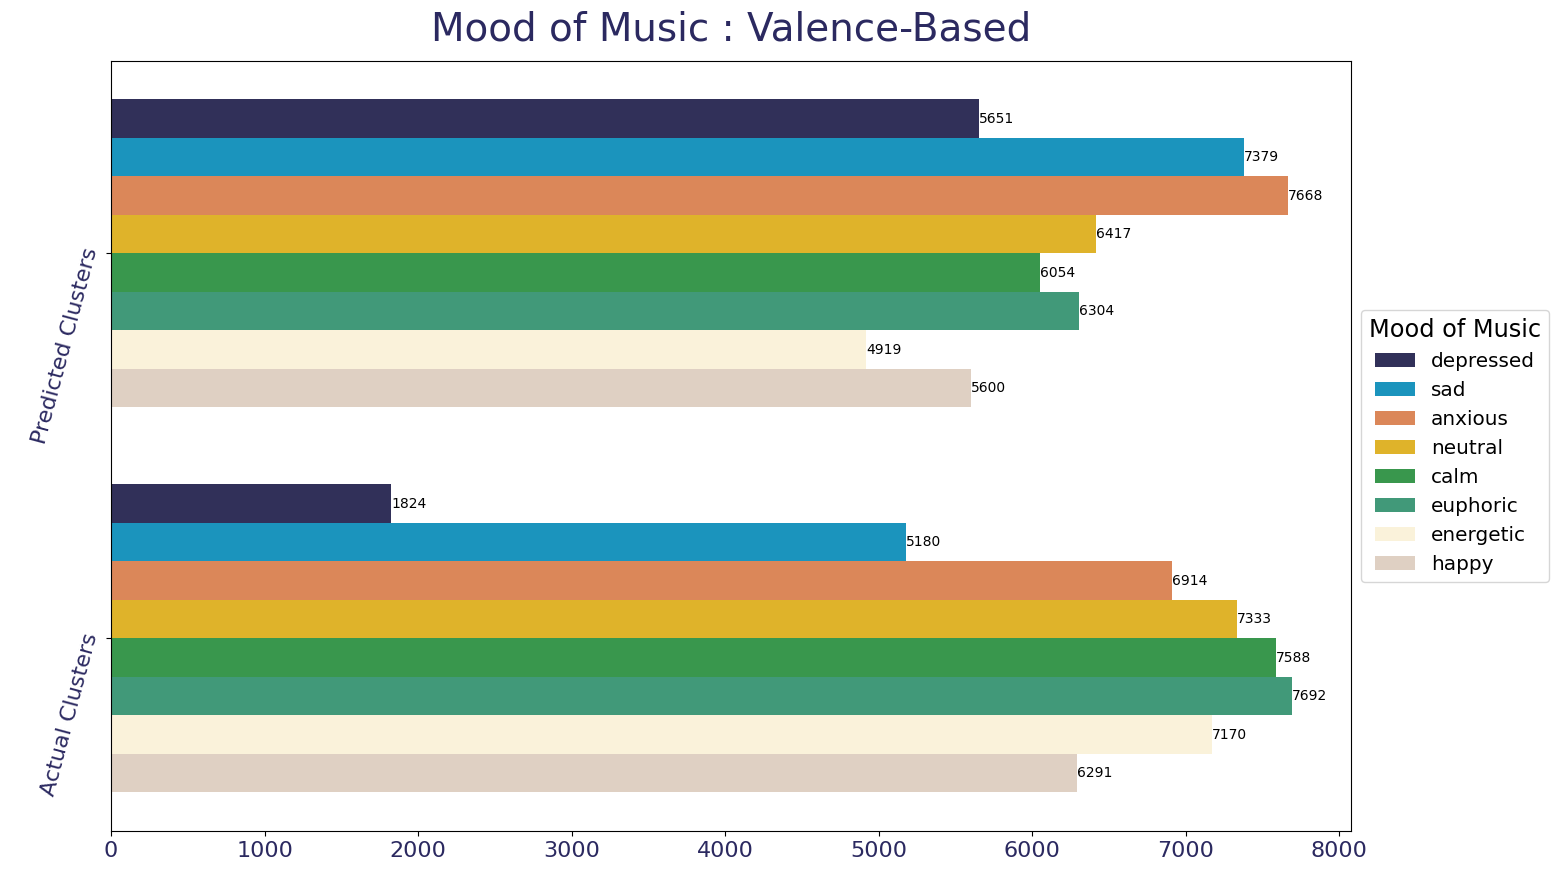

In [176]:

# plot count of data samples in clusters by predicted mood vs actual mood label for the music tracks

final_data_plot = final_data[['k_clusters', 'mood_class']].melt(var_name='Music mood clusters', value_name= 'Mood labels' )

fig, ax = plt.subplots(figsize=(16, 10))

sns.countplot(data= final_data_plot, y='Music mood clusters', hue='Mood labels', color=custom_palette)


#plt.xticks([0, 1], ["Predicted", "Actual"], rotation=45)
plt.yticks([0, 1], ["Predicted Clusters", "Actual Clusters"], rotation=75)


for container in ax.containers:
    ax.bar_label(container)



#plt.xlabel('Count (in Thousands)', fontsize=20, color='#2B2960', labelpad=12);
#plt.ylabel("Clusters", fontsize=20, color='#2B2960', labelpad=10);

plt.xlabel(' ')
plt.ylabel(' ')

plt.title("Mood of Music : Valence-Based", fontsize=28, color='#2B2960', pad=15)

plt.xticks(color='#2B2960',fontsize=16)
plt.yticks(color='#2B2960', fontsize=16)


plt.legend(
    title= "Mood of Music",
    labels = ["depressed", "sad", "anxious",  "neutral", "calm", "euphoric", "energetic", "happy"],
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    fontsize='x-large',
    title_fontsize='xx-large'
    )

# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# mood_of_music_val1dbased.png

<Figure size 1600x1000 with 0 Axes>

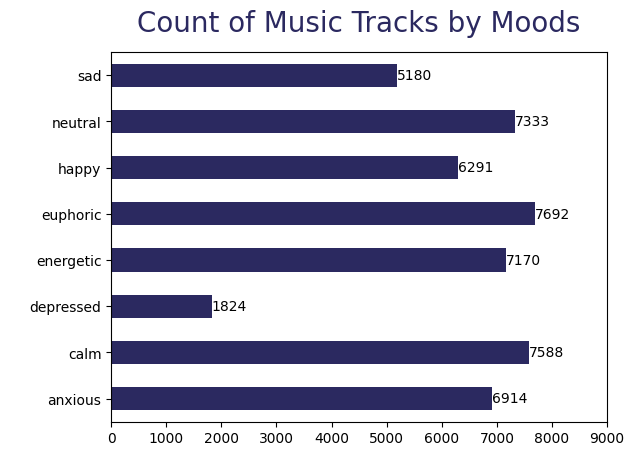

In [173]:

#cmap = custom_cmap_hex

plt.figure(figsize = (16, 10))
#fig, ax = plt.subplots(figsize=(16, 10))
ax.set_facecolor("#FFF4D5")
ax = final_data.groupby('mood_label')[['track_name']].count().plot(kind='barh', colormap = custom_cmap_hex, #color ='#2B2960', 
                                                    xlabel=' ', ylabel=' ', legend= False, xlim = (0, 9000), rot=0)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Count of Music Tracks by Moods", pad=15, fontsize = 20,color='#2B2960')

plt.savefig('../images/mood_count_plot.png', transparent=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time taken for PCA dimension reduction: 0.86 seconds
Time taken for Mini-Batch K-Means: 0.74 seconds
Time taken for t-SNE: 17.45 seconds


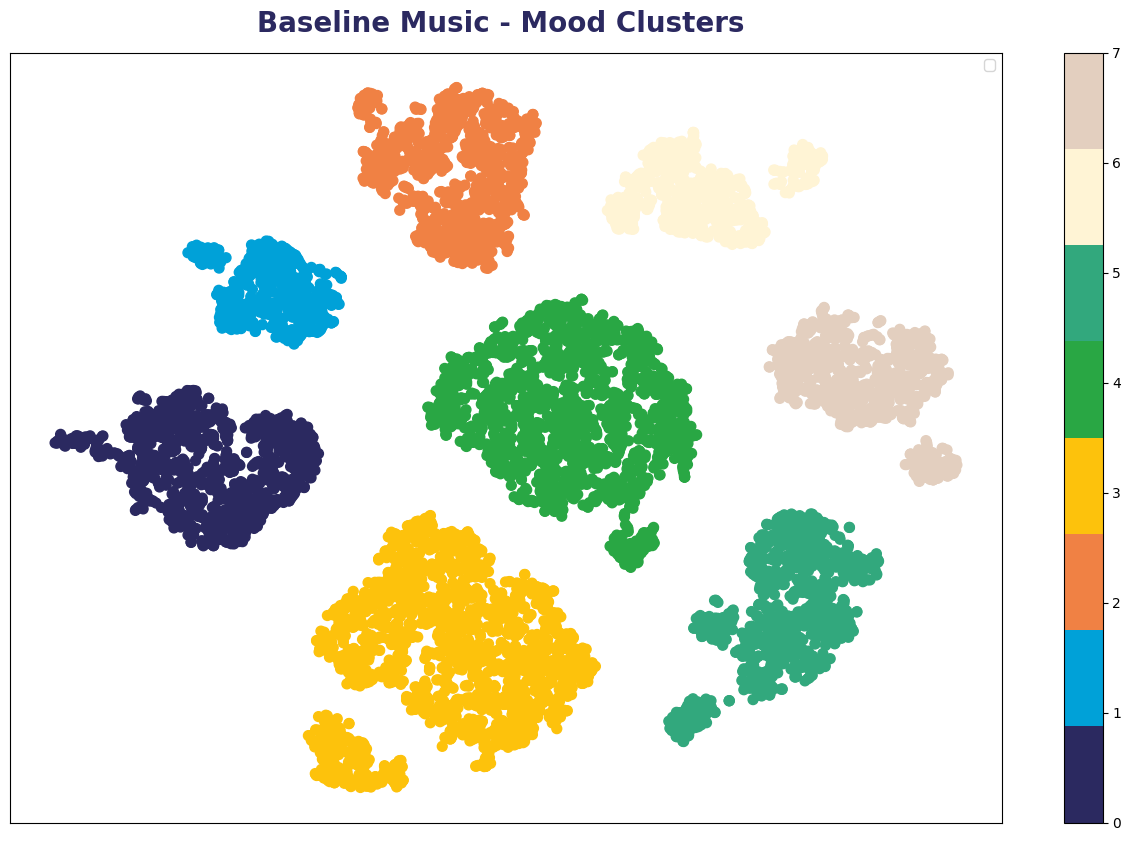

In [76]:
# clustering based on 10,000 samples


cluster_params_1 = {
    'n_clusters' : 8,
    'batch_size' : 5000,
    'random_state' : 42,
    'init' : 'k-means++' #random
}


clustered_data_1, final_data_1, cluster_labels_1, cluster_centers_1, sse_1 = baseline_model(x_train_df, y_train, X_test, cluster_params=cluster_params_1, sample_size = 10000)


---
## Baseline Recommender System : 

* based on music-mood clusters with mini-batch kmeans + tsne visuals

---

In [197]:
a= {'u_choice': 'sad'} #'0'
mood_clusters = {
            "depressed" : 0, 
            "sad" : 1, 
            "anxious" : 2,  
            "neutral" : 3, 
            "calm" : 4, 
            "euphoric" : 5, 
            "energetic" : 6, 
            "happy" : 7
}
if (a['u_choice'] in mood_clusters.keys()) or  (a['u_choice'] in mood_clusters.values()): #('sad', 1):
    choice = mood_clusters[a['u_choice']]
    print(f'yes : {choice}')
else:
    print('no')

print(a['u_choice'])
print(mood_clusters[a['u_choice']])

print(type(mood_clusters[a['u_choice']]))
b = mood_clusters[a['u_choice']]

final_data.query("k_clusters == @b")
#final_data.query("k_clusters == 1")

yes : 1
sad
1
<class 'int'>


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,k_clusters,track_name,mood_label,mood_class
0,0.738866,0.949,0.545455,0.804372,1.0,0.058299,0.083936,0.871000,0.861,0.554403,1,Phat Planet,energetic,6
1,0.743927,0.676,0.636364,0.811595,1.0,0.028838,0.410643,0.017200,0.616,0.485440,1,ให้เธอ,calm,4
9,0.562753,0.756,1.000000,0.900865,1.0,0.033817,0.192771,0.000000,0.411,0.369423,1,Ego,neutral,3
40,0.820850,0.427,0.909091,0.775862,1.0,0.123444,0.443775,0.000165,0.865,0.514232,1,Long As You Love Me,energetic,6
46,0.574899,0.901,0.545455,0.871639,1.0,0.058714,0.000113,0.003510,0.634,0.521381,1,HONEY,euphoric,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49958,0.678138,0.725,0.636364,0.834553,1.0,0.033506,0.192771,0.000000,0.726,0.509365,1,Opel Rekord,euphoric,5
49959,0.523279,0.966,0.636364,0.885449,1.0,0.036411,0.001135,0.705000,0.961,0.529385,1,Satori thème - 2006 Remaster,happy,7
49987,0.581984,0.685,0.454545,0.808795,1.0,0.051763,0.415663,0.133000,0.788,0.430920,1,Middle Of The Night,energetic,6
49989,0.823887,0.741,0.818182,0.885767,1.0,0.374481,0.675703,0.000000,0.878,0.674317,1,Znam Ten Stan,happy,7


In [225]:
# content based recomendation system
# - music track recommendation in a random order using valence clusters based on t-sne baseline model 

# print recommendations based on mood cluster choice

playlist_length = 5 # 10 

mood_clusters = {
            "depressed" : 0, 
            "sad" : 1, 
            "anxious" : 2,  
            "neutral" : 3, 
            "calm" : 4, 
            "euphoric" : 5, 
            "energetic" : 6, 
            "happy" : 7
}


user_current_mood = '1' # sad
moodsic_playlist_choice = 'cluster 4'

mood_choice = {
        'user_current_mood' :'sad', #sad
        'moodsic_playlist_choice':'happy' #happy 
}


def baseline_recommender(playlist_length= playlist_length, mood_clusters = mood_clusters, mood_choice= mood_choice, *args, **kwargs):

    mood_list_types = ["depressed", 0, "sad", 1, " anxious", 2, "neutral", 3, "calm", 4, "euphoric", 5, "enegertic", 6, "happy", 7]

    # cluster 1 : depressed (0)
    if (mood_choice['user_current_mood'] in mood_list_types) and (mood_choice['moodsic_playlist_choice'] in mood_list_types):    

        choice = mood_clusters[mood_choice['moodsic_playlist_choice']]
        query_data = final_data.query("k_clusters == @choice")


    else:
        raise ValueError("Input mood cluster choice is unavailable .... specified only! ")


    print("________"*10)

    print(f"Recommended music tracks based on {mood_choice['moodsic_playlist_choice']} : \n ")


    for music in query_data:
        print(f" Enjoy these {playlist_length} music tracks from spotify")
        print("             "*10)
        n_mood_music = (query_data[['track_name', 'k_clusters', 'mood_class', 'mood_label']].sample(n=playlist_length, random_state = 42, replace=False))


        print("________"*10)
        print(n_mood_music['track_name'])

        print("________"*10)
        print("________"*10)

        # option : print dataframe with music name, by which artist and spotify url
        break

    return n_mood_music



In [226]:
# display recomendations and print recommendation dataframe


n_mood_music = baseline_recommender(playlist_length = playlist_length, **mood_choice)

print("________"*10)

n_mood_music



________________________________________________________________________________
Recommended music tracks based on happy : 
 
 Enjoy these 5 music tracks from spotify
                                                                                                                                  
________________________________________________________________________________
42792                                  To Have And To Hold
38089    Anyplace, Anywhere, Anytime - Special 12" Danc...
17832                                            Red Stars
22473                                  You & Me - Me & You
26903                                                Bang!
Name: track_name, dtype: string
________________________________________________________________________________
________________________________________________________________________________
________________________________________________________________________________


,track_name,k_clusters,mood_class,mood_label
42792,To Have And To Hold,7,3,neutral
38089,"Anyplace, Anywhere, Anytime - Special 12"" Danc...",7,2,anxious
17832,Red Stars,7,3,neutral
22473,You & Me - Me & You,7,5,euphoric
26903,Bang!,7,5,euphoric


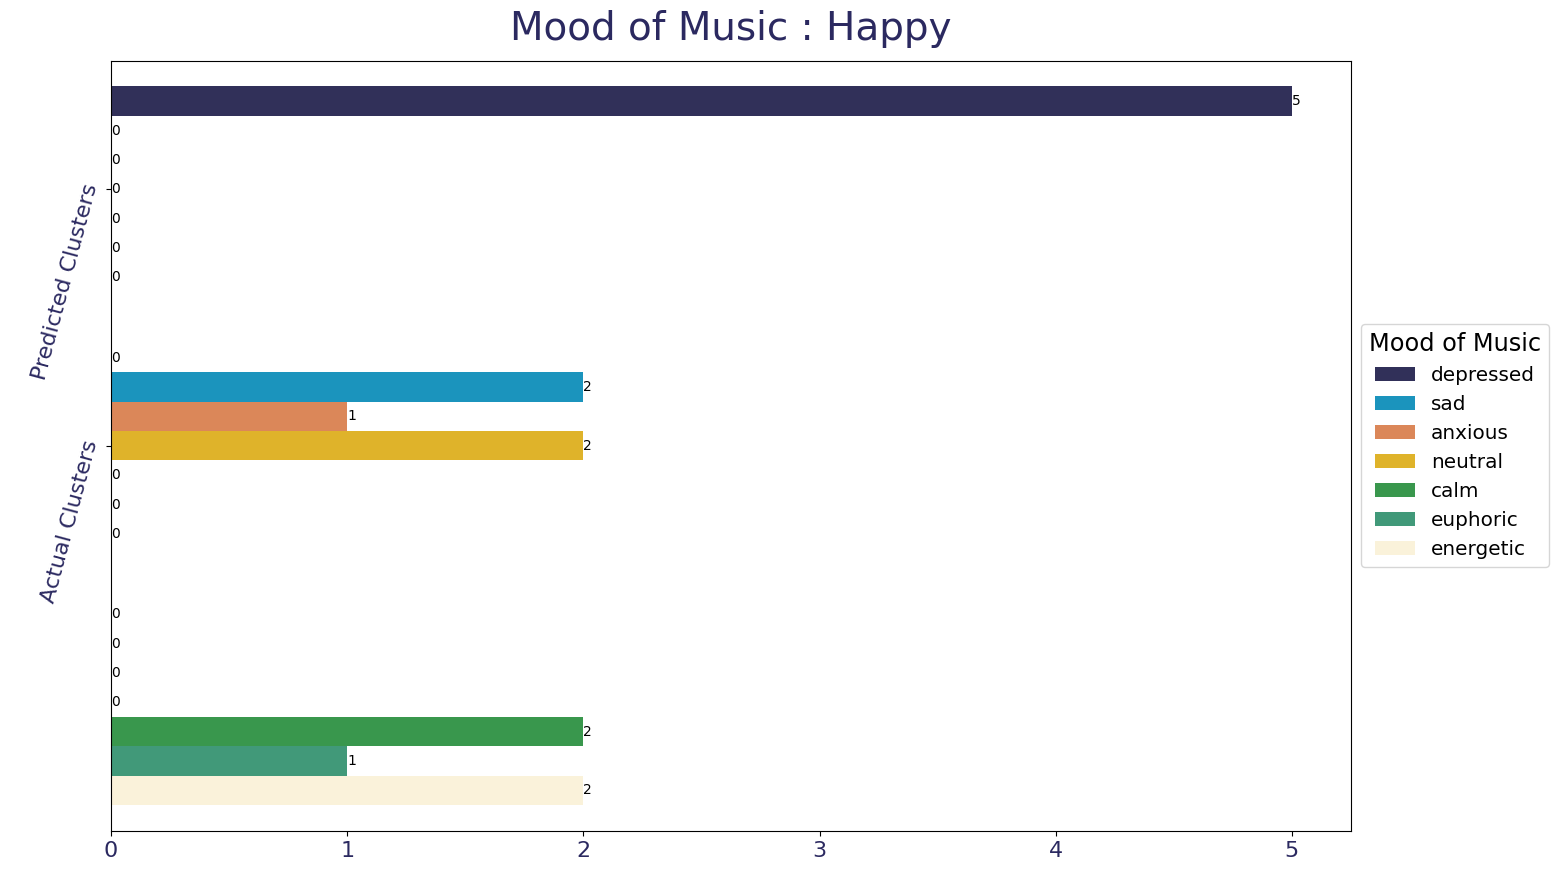

In [229]:

# plot count of data samples in clusters by predicted mood vs actual mood label for the music tracks

rec_data_plot = n_mood_music[['k_clusters', 'mood_class']].melt(var_name='Music mood clusters', value_name= 'Mood labels' )

fig, ax = plt.subplots(figsize=(16, 10))

ind = np.arange(2)
width = 0.3       


plt.bar(n_mood_music['k_clusters'],, width, label="Predicted Clusters")
plt.bar(n_mood_music['mood_class'] + width,  width, label="Actual Clusters")



plt.bar(data= rec_data_plot, y='Music mood clusters', hue='Mood labels', color=custom_palette)
plt.bar(data= rec_data_plot, y='Music mood clusters', hue='Mood labels', color=custom_palette)


plt.yticks([0, 1], ["Predicted Clusters", "Actual Clusters"], rotation=75)


for container in ax.containers:
    ax.bar_label(container)

plt.xlabel(' ')
plt.ylabel(' ')

plt.title("Mood of Music : Happy", fontsize=28, color='#2B2960', pad=15)

plt.xticks(color='#2B2960',fontsize=16)
plt.yticks(color='#2B2960', fontsize=16)


plt.legend(
    title= "Mood of Music",
    labels = ["depressed", "sad", "anxious",  "neutral", "calm", "euphoric", "energetic", "happy"],
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    fontsize='x-large',
    title_fontsize='xx-large'
    )

# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# mood_of_music_val1dbased.png

---

# Recommendation : Error Analysis and Evaluation

* Offline Metrics
    Based on the mood clustering
    - Classification report
    - Similarity score 

* Online Metrics
    Based on user usage: mood choices and filtering
    - Click through rate
    - A-B test
    - Churn
    - Product usage time

---

In [231]:
(n_mood_music['k_clusters'].to_numpy()).shape

(5,)

In [233]:
baseline_rec_preds = n_mood_music.copy(deep=True)

baseline_rec_preds


,track_name,k_clusters,mood_class,mood_label
42792,To Have And To Hold,7,3,neutral
38089,"Anyplace, Anywhere, Anytime - Special 12"" Danc...",7,2,anxious
17832,Red Stars,7,3,neutral
22473,You & Me - Me & You,7,5,euphoric
26903,Bang!,7,5,euphoric


In [243]:
# check the rand index score for the recommended score 
from sklearn.metrics import rand_score


rec_metrics = [
        # (n_samples, )
        metrics.rand_score,
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.mutual_info_score,
    ]

print(f"For the baseline recommendation system:  ")

for metric in rec_metrics:
    #score_labels = metric(y_true_label.values, cluster_labels)
    score_class = metric(n_mood_music['k_clusters'].to_numpy(), n_mood_music['mood_class'].to_numpy())
    print(f"{metric.__name__} of: {score_class:.2f} ")

print('_______'*10)


#similarity_metric = rand_score()
#RI_recsys = similarity_metric(n_mood_music['k_clusters'].to_numpy(), n_mood_music['mood_class'].to_numpy())
#RI_recsys = rand_score(n_mood_music['k_clusters'].to_numpy(), n_mood_music['mood_class'].to_numpy())
#RI_rate_rec = RI_recsys * 100
#print(f"The baseline model predicted clusters for the {similarity_metric} is approximately {RI_rate_rec:.2f} % similar to the actual music-mood (1-D) clusters")






For the baseline recommendation system:  
rand_score of: 0.20 
homogeneity_score of: 1.00 
completeness_score of: 0.00 
v_measure_score of: 0.00 
mutual_info_score of: 0.00 
______________________________________________________________________
